> With Factorization Machines, multi-dimensional, feature-rich databases can be used and meta data can be used for finding out useful features as well.

>Our dataset is fairly sparse as even bigger datasets have been reduced so as to make them easier to work with.

## Collaborative Filtering for generating User and Item Features using Matrix Decomposition


In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display, HTML

### Data

[MovieLens 100K Movie Recommendation Data](https://grouplens.org/datasets/movielens/100k/)


### Second Order Factorization Model

$$ \widehat{y}\left ( x \right ) = w_{0}  + \sum_{i=1}^{n}w_{i}x_{i} + \sum_{i=1}^{n}\sum_{j=i+1}^{n}<v_{i}v_{j}>x_{i}x_{j} $$


>v : k dimensional latent vectors associated with each variable

>w0 : global bias

>wi : user-item specific bias

>xi xj : user-item interaction

#### Ratings

$$ \hat{r} = \vec{u}^t \vec{p} $$

>The ratings in this model have been taken as the inner product of the two vectors. The User Vector 'u' and the Vector with the Latent Values.



### Get the Dataset

In [2]:
MovieLensData = pd.read_csv("../Datasets/MovieLens/ml-100k/ml-100k/u.data", delimiter="\t",names = ["user","item","rate","time"])

>Here we are using the GoupLens MovieLens Dataset which contains data on different users, and different movies and the ratings each of the users have given to individual movies. 

### Instantiate Session for running the TensorFlow Graph

In [3]:
sess = tf.Session()
init = tf.initialize_all_variables()

Instructions for updating:
Use `tf.global_variables_initializer` instead.


### Create Sample for Training the Model

> Here we are considering the training size as 70% of the datasets on top of which the predictions would take place.

> We are taking 70% of the values withouit replacement from the dataset at random.

In [4]:
train_size = np.random.rand(len(MovieLensData)) < 0.7
_train = MovieLensData[train_size]

### Create lists for the User Ids and Item Ids and the respective ratings attributed

In [5]:
user_indecies = [x-1 for x in _train.user.values]
item_indecies = [x-1 for x in _train.item.values]
rates = _train.rate.values

### Defining the maximum nuber of features to be extracted

In [6]:
feature_len = 10

### Defining New User and Item Matrices with their vectors as the feature vectors.

>In the case of the User Matrix we have the Feature Column.

>In the case of the Item Matrix we have the Feature Row.

>##### tf.truncated_normal(shape, mean=0.0, stddev=1.0, dtype=tf.float32, seed=None, name=None)

>Outputs random values from a truncated normal distribution.

>The truncated normal distribution is the probability distribution of a normally distributed random variable whose value is either bounded below or above (or both). 

In [7]:
U = tf.Variable(initial_value=tf.truncated_normal([943,feature_len]), name='user')
P = tf.Variable(initial_value=tf.truncated_normal([feature_len,1682]), name='item')

### Defining the result 
>This yields us the ratings obtained after defining the features.

In [8]:
result = tf.matmul(U, P)

### Flattening the "result" Matrix
>##### Flattening Example

>tensor 't' [[[1, 1, 1], [2, 2, 2]], [[3, 3, 3],[4, 4, 4]],[[5, 5, 5],[6, 6, 6]]]

>tensor 't' has shape [3, 2, 3]

>pass '[-1]' to flatten 't'

>reshape(t, [-1]) ==> [1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5, 6, 6, 6]

### tf.gather(params, indices, validate_indices=None, name=None)
>Gather slices from params according to indices

>indices must be an integer tensor of any dimension (usually 0-D or 1-D). Produces an output tensor with shape indices.shape + params.shape[1:]

In [9]:
result_flatten = tf.reshape(result, [-1])

R = tf.gather(result_flatten, user_indecies * tf.shape(result)[1] + item_indecies, name='extracting_user_rate')

## Regularization and the Loss Function

$$ min\sum_{i=1}^{n}V(f(\hat{x}_i)f(\hat{y}_i)) + \lambda P(f) $$

for a loss function $$ {\displaystyle V} $$ that describes the cost of predicting $$ {\displaystyle f(x)} 
$$ when the label is $$ {\displaystyle y} $$, such as the square loss or hinge loss, and for the term $$ {\displaystyle \lambda } $$ which controls the importance of the regularization term. $$ {\displaystyle P(f)} $$ is typically a penalty on the complexity of $$ {\displaystyle f} $$, such as restrictions for smoothness or bounds on the vector space norm.


### Difference between the Random Values and the Actual Values

In [10]:
diff_op = tf.sub(R, rates, name='trainig_diff')
diff_op_squared = tf.abs(tf.square(diff_op, name="squared_difference"))

### Computing Base Cost

$$  min\sum_{i=1}^{n}V(f(R)f(rates)) $$

In [11]:
base_cost = tf.reduce_sum(diff_op_squared, name="sum_squared_error")

### Computing Norm and defining lambda

Norm : $$  f $$ 
Lambda: $$ \lambda$$


In [12]:
lda = tf.constant(.001, name='lambda') #lambda
norm_sums = tf.add(
    tf.reduce_sum(tf.abs(U, name='user_abs'), name='user_norm'), 
    tf.reduce_sum(tf.abs(P, name='item_abs'), name='item_norm')) # sum of the U and P Matrices taken as norms

### Computing Regularization Function 

$$ \lambda P(f) $$

In [13]:
regularizer = tf.mul(norm_sums, lda, 'regularizer') #nultiply the P(f) and lambda

### Obtaining the Final Loss Function

$$\sum_{i=1}^{n}V(R)f(rates) + \lambda P(f)$$

In [14]:
cost = tf.add(base_cost, regularizer)

## Learning/Training Model
### Defining the rate at which the model learns


>Here, we can see that the exponential decay function is used for the learning rate as we don't want the model to keep learning continuously.

>We have tuned the decay model such that the model decays for the next 10000 steps with a decay rate of 0.96 from the base learning rate of 0.001 

In [15]:
lr = tf.constant(.001, name='learning_rate')
global_step = tf.Variable(0, trainable=False)
learning_rate = tf.train.exponential_decay(lr, global_step, 10000, 0.96, staircase=True)

### Defining the Optimization Method for the Learning Model

>##### Gradient Descent Optimizer

>Gradient descent is an optimization algorithm used to find the values of parameters (coefficients) of a function (f) that minimizes a cost function (cost).

>It is best used when the parameters cannot be calculated analytically (e.g. using linear algebra) and must be searched for by an optimization algorithm.

In [16]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate)
training_step = optimizer.minimize(cost, global_step=global_step)

### Final Optimized Cost Function

$$ min\sum_{i=1}^{n}V(f(R)f(rates)) + \lambda P(f) $$

After going through all the above steps we have arrived at the preferred equation which would be an instance of training for our Learning Model.

### Initializing all the Variables

>In Tensorflow none of the objects or variables output anyting till they have been initialized. After they are initialized, only then are they stored as TF operations and only then after that they can be evaluated within the session.

In [17]:
init = tf.initialize_all_variables()
sess.run(init)

Instructions for updating:
Use `tf.global_variables_initializer` instead.


### Displaying Matrices

> Here we can see that the U and P, the User and Item Matrices respectively, which have been formed through Matrix Decomposition have inner vectors which are of size 10.

> These 10 vectors are the 10 feature vectors which define 10 quantified features for each individual Item in the Item Matrix and each individual User in the User Matrix.

In [18]:
display(sess.run(U))
display(sess.run(tf.shape(U)))

display(sess.run(P))
display(sess.run(tf.shape(P)))

display(sess.run(result))
display(sess.run(tf.shape(result)))

array([[-0.81220341,  0.37058678,  1.24118137, ...,  1.46901143,
        -0.70671052, -1.8305186 ],
       [ 0.02922708, -0.72013128, -0.00801589, ...,  1.15356469,
         1.68524218,  1.85763836],
       [ 0.22098094,  0.15062393, -1.60873449, ..., -1.59152067,
         1.54848826, -1.01640308],
       ..., 
       [ 0.00941658,  1.20050681,  1.68613267, ...,  1.13435674,
        -0.15135647,  0.53235   ],
       [ 0.43751195, -1.15487123, -1.51693213, ..., -0.08659396,
        -0.19608822, -0.72341734],
       [ 0.83507311,  0.51638842,  0.18813764, ...,  1.27671206,
        -0.40238461, -1.47999048]], dtype=float32)

array([943,  10])

array([[ 1.90545261,  1.28037536,  0.21271086, ..., -1.24561608,
         1.14141893,  1.05037296],
       [-0.95732647, -0.62929004, -0.41205209, ..., -1.42195582,
         0.09077808, -1.70308053],
       [ 0.50202435,  0.11062878, -0.92459714, ...,  1.43245995,
         0.12757578, -1.66804886],
       ..., 
       [-0.77566946, -0.36765468, -0.61928439, ...,  1.06997466,
        -1.13820994,  0.3719511 ],
       [-1.70025241, -0.14404662, -0.31020194, ...,  0.73789245,
         0.00491412, -0.76003218],
       [-0.40508029, -0.03904512, -0.55874455, ...,  0.03536268,
         1.63393378, -1.60653794]], dtype=float32)

array([  10, 1682])

array([[ -2.14488888e+00,  -1.94769800e+00,  -3.13238287e+00, ...,
          3.14458203e+00,  -6.87793684e+00,   8.29592943e-01],
       [ -2.43351912e+00,  -2.89005995e-01,  -9.60190594e-01, ...,
          3.27938843e+00,   2.72818971e+00,  -3.14032292e+00],
       [  3.78467619e-01,  -6.72436833e-01,   2.20943713e+00, ...,
         -4.12038136e+00,  -7.70708680e-01,   3.06850100e+00],
       ..., 
       [ -2.67243838e+00,   6.11859143e-01,  -2.02758646e+00, ...,
          2.74572253e+00,   1.54658270e+00,  -5.83679104e+00],
       [  3.46367091e-01,   3.25373697e+00,   3.17765307e+00, ...,
          2.07420625e-03,  -3.71386826e-01,   6.89496231e+00],
       [  2.64637637e+00,   1.25727475e+00,  -4.24946904e-01, ...,
         -5.12097776e-01,  -2.46775651e+00,   2.85939717e+00]], dtype=float32)

array([ 943, 1682])

### Running the Training Model



In [19]:
costs = []
costs2 = []
actual_rate = []
predicted_rates = []
for epochs in range(100):
    for i in range(epochs):
        sess.run(training_step)
    
    u, p, r = MovieLensData[['user', 'item', 'rate']].values[7]
    rhat = tf.gather(tf.gather(result, u-1), p-1)
    print( "rating for user " + str(u) + " for item " + str(p) + 
          " is " + str(r) + " and our prediction is: " + str(sess.run(rhat)))
    actual_rate.append(r)
    predicted_rates.append(sess.run(rhat))

    df_test = MovieLensData[~train_size]
    user_indecies_test = [x-1 for x in df_test.user.values]
    item_indecies_test = [x-1 for x in df_test.item.values]
    rates_test = df_test.rate.values
    R_test = tf.gather(result_flatten, user_indecies_test * tf.shape(result)[1] + item_indecies_test, name='extracting_user_rate_test')
    diff_op_test = tf.sub(R_test, rates_test, name='test_diff')
    diff_op_squared_test = tf.abs(diff_op, name="squared_difference_test")

    cost_test = tf.div(tf.reduce_sum(tf.square(diff_op_squared_test, name="squared_difference_test"), name="sum_squared_error_test"), df_test.shape[0] * 2, name="average_error")
    costs.append(sess.run(cost_test))
    cost_test2 = tf.div(tf.reduce_sum((diff_op_squared_test), name="sum_squared_error_test"), df_test.shape[0] * 2, name="average_error")
    costs2.append(sess.run(cost_test2))
    print(sess.run(cost_test))

rating for user 253 for item 465 is 5 and our prediction is: 1.91077
22.8756
rating for user 253 for item 465 is 5 and our prediction is: 1.81087
18.146
rating for user 253 for item 465 is 5 and our prediction is: 2.13749
15.0613
rating for user 253 for item 465 is 5 and our prediction is: 3.99948
6.01734
rating for user 253 for item 465 is 5 and our prediction is: 4.13264
2.40418
rating for user 253 for item 465 is 5 and our prediction is: 3.69467
2.73345
rating for user 253 for item 465 is 5 and our prediction is: 2.88029
4.24694
rating for user 253 for item 465 is 5 and our prediction is: 3.56331
3.63945
rating for user 253 for item 465 is 5 and our prediction is: 3.64076
3.27738
rating for user 253 for item 465 is 5 and our prediction is: 3.01023
5.03861
rating for user 253 for item 465 is 5 and our prediction is: 3.02325
4.13409
rating for user 253 for item 465 is 5 and our prediction is: 3.58138
2.33654
rating for user 253 for item 465 is 5 and our prediction is: 3.62383
2.26133


### Plotting Results for Evaluation

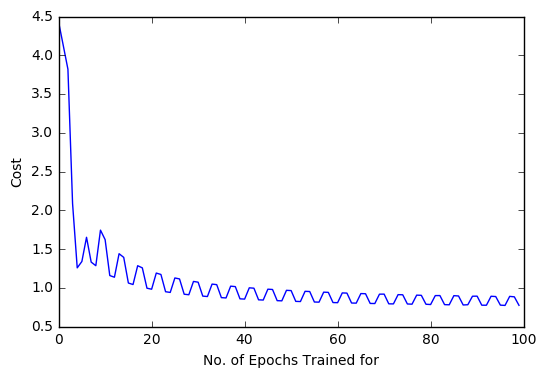

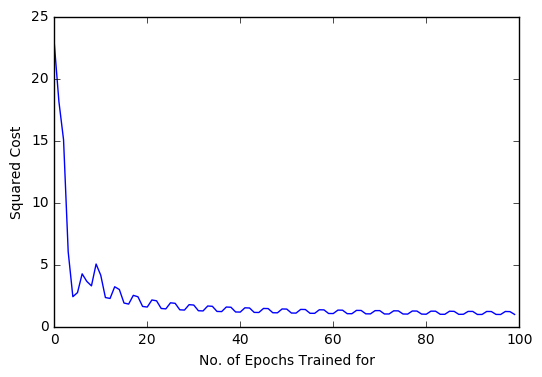

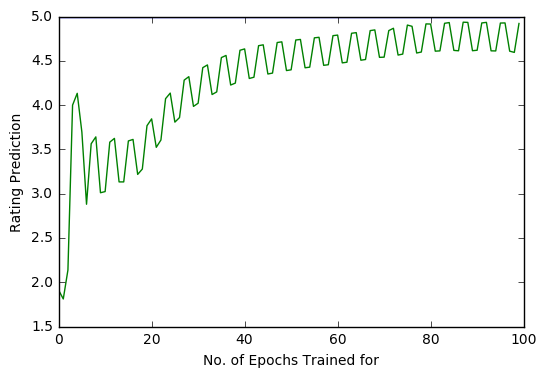

In [20]:
plt.plot(costs2)

plt.xlabel("No. of Epochs Trained for")
plt.ylabel("Cost")
plt.show()

plt.plot(costs)

plt.xlabel("No. of Epochs Trained for")
plt.ylabel("Squared Cost")
plt.show()

plt.plot(actual_rate)
plt.plot(predicted_rates)

plt.xlabel("No. of Epochs Trained for")
plt.ylabel("Rating Prediction")
plt.show()